## ガウス過程回帰

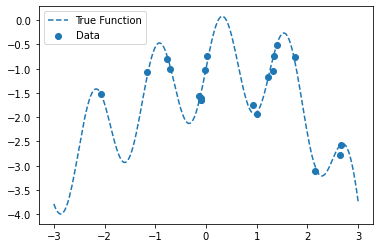

In [377]:
import numpy as np
import matplotlib.pyplot as plt
import random

def true_func(x):
    """
    正しい関数
    
    :param np.array x:
    :return: 関数値 y
    :rtype: np.array
    """
    y = x + np.sin(5 * x) - np.exp(x/1.5)
    return y

x_all = np.linspace(-3., 3., 200)
index_initial = np.random.randint(0, len(x_all), 20).tolist()
index_test = [num for num in np.arange(len(x_all)) if num not in index_initial]

np.random.seed(1)
x_train = x_all[index_initial]
y_train = true_func(x_train) + np.random.normal(loc=0, scale=.1, size=x_train.shape)
x_test = x_all[index_test]
y_test = true_func(x_test) + np.random.normal(loc=0, scale=.1, size=x_test.shape)
plt.scatter(x_train, y_train, label="Data");
plt.plot(x_test, true_func(x_test), "--", color="C0", label="True Function");
plt.legend();
#plt.title("トレーニングデータ");

In [311]:
from sklearn.gaussian_process import kernels as sk_kern
from sklearn.gaussian_process import GaussianProcessRegressor

kernel = sk_kern.RBF(1.0, (1e-3, 1e3)) + sk_kern.ConstantKernel(1.0, (1e-3, 1e3)) + sk_kern.WhiteKernel()
clf = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-10, 
    optimizer="fmin_l_bfgs_b", 
    n_restarts_optimizer=20,
    normalize_y=True)

In [312]:
# X は (n_samples, n_features) の shape に変形する必要がある
clf.fit(x_train.reshape(-1, 1), y_train)

# パラメータ学習後のカーネルは self.kernel_ に保存される
clf.kernel_ # < RBF(length_scale=0.374) + 0.0316**2 + WhiteKernel(noise_level=0.00785)

# 予測は平均値と、オプションで 分散、共分散 を得ることが出来る
pred_mean, pred_std= clf.predict(x_test.reshape(-1, 1), return_std=True)

C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [313]:
x_test.reshape(1, -1)[0]

array([-3.        , -2.96984925, -2.90954774, -2.87939698, -2.84924623,
       -2.78894472, -2.75879397, -2.72864322, -2.69849246, -2.63819095,
       -2.6080402 , -2.57788945, -2.54773869, -2.51758794, -2.48743719,
       -2.45728643, -2.42713568, -2.39698492, -2.36683417, -2.33668342,
       -2.30653266, -2.27638191, -2.24623116, -2.18592965, -2.12562814,
       -2.09547739, -2.06532663, -2.03517588, -2.00502513, -1.97487437,
       -1.94472362, -1.91457286, -1.85427136, -1.8241206 , -1.79396985,
       -1.7638191 , -1.73366834, -1.70351759, -1.67336683, -1.64321608,
       -1.58291457, -1.55276382, -1.52261307, -1.49246231, -1.46231156,
       -1.4321608 , -1.40201005, -1.3718593 , -1.34170854, -1.31155779,
       -1.28140704, -1.22110553, -1.19095477, -1.16080402, -1.13065327,
       -1.10050251, -1.07035176, -1.04020101, -1.01005025, -0.9798995 ,
       -0.94974874, -0.91959799, -0.88944724, -0.85929648, -0.82914573,
       -0.79899497, -0.76884422, -0.73869347, -0.70854271, -0.67

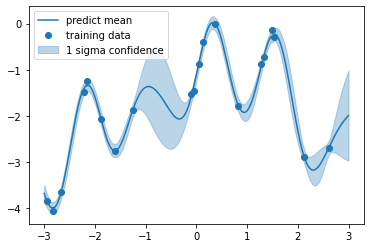

In [314]:
def plot_result(x_test, mean, std):
    plt.plot(x_test, mean, color="C0", label="predict mean");
    plt.fill_between(x_test, mean + std, mean - std, color="C0", alpha=.3,label= "1 sigma confidence");
    plt.plot(x_train, y_train, "o",label= "training data");

plot_result(x_test.reshape(1, -1)[0], pred_mean, pred_std)
#plt.title("Scikit-learn による予測");
plt.legend();

改善確率(probability of improvement, PI)  


In [378]:
from scipy.stats import norm

def probability_improvement(x_new, gaussian_process, evaluated_loss, greater_is_better=False):
    assert type(evaluated_loss) is np.ndarray, "evaluated_loss must be np.array"
    if len(x_new.shape)==1:
        x_new = x_new.reshape(1, -1)
    mu, sigma = gaussian_process.predict(x_new, return_std=True)
    
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)
    
    scaling_factor = (-1) ** (greater_is_better)
    with np.errstate(divide='ignore'):
        Z = loss_optim / sigma
        proba_improvement = norm.cdf(scaling_factor*Z)
        proba_improvement[sigma == 0.0] == 0.0
    if len(proba_improvement.shape)==1:
        proba_improvement = proba_improvement.reshape(-1, 1)
    return proba_improvement

期待改善度(expected improvement, EI)  

In [379]:
def expected_improvement(x_new, gaussian_process, evaluated_loss, greater_is_better=False):
    assert type(evaluated_loss) is np.ndarray, "evaluated_loss must be np.array"
    if len(x_new.shape)==1:
        x_new = x_new.reshape(1, -1)
    mu, sigma = gaussian_process.predict(x_new, return_std=True)
    
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)
    
    scaling_factor = (-1) ** (not greater_is_better)
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma==0.0] == 0.0
    return ei

信頼上限(upper confidence, UI)  


In [380]:
def confidence_bound(x_new, gaussian_process, evaluated_loss, greater_is_better=False):
    assert type(evaluated_loss) is np.ndarray, "evaluated_loss must be np.array"
    if len(x_new.shape)==1:
        x_new = x_new.reshape(1, -1)
    mu, sigma = gaussian_process.predict(x_new, return_std=True)
    n_samples = evaluated_loss.shape[0]
    with np.errstate(divide='ignore'):
        kappa = np.sqrt(np.log(n_samples)/n_samples)
        if greater_is_better:
            cb = mu + kappa * sigma
        else:
            cb = mu + kappa * sigma
    return cb

In [381]:
from sklearn.gaussian_process import kernels
from sklearn.gaussian_process.kernels import ConstantKernel as C

k1 = kernels.Sum(C()*kernels.RBF(), C()*kernels.RationalQuadratic())
k2 = kernels.Sum(C()*kernels.Matern(), C()*kernels.ExpSineSquared())
k3 = kernels.Sum(C()*kernels.DotProduct(), C()*kernels.ConstantKernel())
ks = kernels.Sum(k1, k2)
ks = kernels.Sum(ks, k3)
sum_kernels = kernels.Sum(ks, kernels.WhiteKernel())

In [382]:
import sklearn.gaussian_process as gp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

gpr = make_pipeline(StandardScaler(),
                    gp.GaussianProcessRegressor(kernel=sum_kernels, normalize_y=True))

In [408]:
gpr.fit(x_train.reshape(-1, 1), y_train)
EI = [expected_improvement(x_all.reshape(-1, 1)[idx,:], gpr, y_train, greater_is_better=True).reshape(-1,) for idx in index_test]

subindex_max = np.array(EI).argmax()
x_train = np.r_[x_train.reshape(-1, 1), x_test.reshape(-1, 1)[subindex_max,:].reshape(1,-1)]
y_train = np.r_[y_train.reshape(-1, 1), y_test.reshape(-1, 1)[subindex_max,:].reshape(-1,1)]

index_initial.append(index_test.pop(subindex_max))
x_test = x_all.reshape(-1, 1)[index_test,:]

C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing th

33


C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k2__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified lower bound 1e-05. Decreas

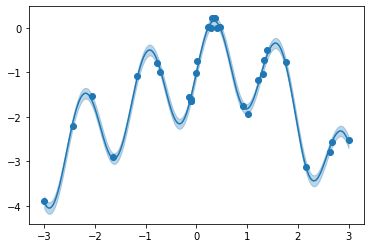

In [409]:
print(len(x_train))
gpr.fit(x_train.reshape(-1, 1), y_train)
pred_mean, pred_std= gpr.predict(x_all.reshape(-1, 1), return_std=True)

plot_result(x_all.reshape(1, -1)[0], pred_mean.reshape(1, -1)[0], pred_std.reshape(1, -1)[0])